# MachineMax Technical Test - Stretch Goals

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, auc, classification_report
from xgboost import XGBClassifier
from Codebase.models import TimeSeriesModelEvaluator
from Codebase.statistical_models import LinearRegressionPredictor
import ruptures as rpt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Loading Data

In [2]:
df = pd.read_csv('./data/time-series1.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head(200)

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000,0,0,1,2,0.000000,0.000263
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000,0,0,1,2,0.001346,0.001721
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000,0,0,1,2,0.002692,0.001304
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000,0,0,1,2,0.004038,0.001377
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000,0,0,1,2,0.005384,0.001670
...,...,...,...,...,...,...,...,...,...,...
195,506.705862,States.ACTIVE,2021-01-01 00:32:30,1609461150000000000,1,0,0,0,0.262450,0.591398
196,466.630940,States.ACTIVE,2021-01-01 00:32:40,1609461160000000000,1,0,0,0,0.263795,0.544624
197,547.582753,States.ACTIVE,2021-01-01 00:32:50,1609461170000000000,1,0,0,0,0.265141,0.639108
198,587.969861,States.ACTIVE,2021-01-01 00:33:00,1609461180000000000,1,0,0,0,0.266487,0.686247


---
## Time-Segment Identification

### Change-Point Detection

- **Cost Function**: Define a cost function for each segment of the data. The cost function represents how well a model (such as constant mean or constant variance) fits to the data in the segment. For example, a simple cost function could be the sum of squared residuals of the model.

- **Penalty Term**: Define a penalty term that gets added to the total cost every time a change point is added. The penalty term controls the trade-off between the fit to the data and the number of change points. The larger the penalty, the fewer change points are detected.

- **Dynamic Programming**: Use dynamic programming to find the segmentation with the minimum total cost. This involves computing the optimal segmentation for smaller parts of the data and combining these results to find the optimal segmentation of the whole data.

- **Pruning**: Use a pruning rule to discard segmentations that cannot possibly be optimal. This step makes the algorithm faster and allows it to run in linear time.

The key advantage of PELT is its computational efficiency. Traditional change point detection methods have a time complexity of O(n log n) or worse. In contrast, the PELT algorithm has a time complexity of O(n), which makes it suitable for large datasets and real-time applications.

Once Change-Point detection is done, you can take a window across each of the change-points and determine if the overall slope for the window is positive or negative (+ meaning ACTIVE or IDLE, - meaning IDLE or OFF). From there, OFF values can be assumed to be anything below a set threshold. Then, logic can be applied such that if the previous state was OFF and there is a positive trend, the next state will be IDLE etc.

Alternativlely, you can generate some metrics about each interval (mean, std, var, min, max, etc.) which can be used to feed into a ML model that classifies each interval.

**Limitations**:

- Very small sample size for training if using each interval as a data-point for an ML model, making it nearly impossible to train a model for this specific data-sample.

- Compounding errors introduced by the change-point detection algorithm can affect the performance of the overall model, adding another point of failure for the system.

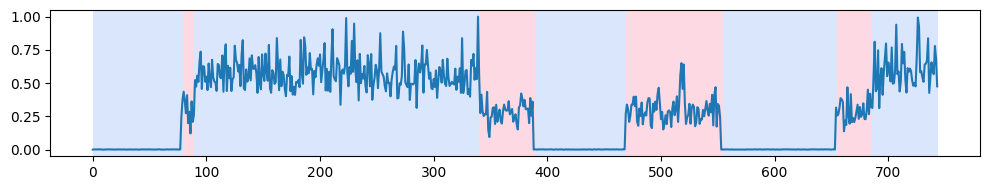

In [12]:
# Load the rms values
rms_values = df['rms_scaled']

# Convert the data into a numpy array
series = np.array(rms_values)

# Define the change-point detection model using the PELT algorithm
model = "rbf"  # can be "l2", "rbf", "linear", "normal", etc.
algo = rpt.Pelt(model=model).fit(series)

# Perform change-point detection
result = algo.predict(pen=5)  # Adjust the pen parameter to control the sensitivity

# Plot the results
rpt.display(series, result)
plt.show()

In [10]:
# Generating Features
rms_values = []
timestamps = []
states = []
previous_item = -1

for i, item in enumerate(result):
    rms_interval = df['rms_scaled'].iloc[previous_item+1:item].values
    timestamps_interval = df['timestamp_scaled'].iloc[previous_item+1:item].values
    state = df['state_encoded'].iloc[previous_item+1]

    rms_values.append(rms_interval)
    timestamps.append(np.sum(timestamps_interval[-1] - timestamps_interval[0]))
    states.append(state)

    previous_item = item

metrics_list = []

for array in rms_values:
    metrics = {}
    metrics['mean'] = np.mean(array)        # Mean
    metrics['std'] = np.std(array)          # Standard Deviation
    metrics['var'] = np.var(array)          # Variance
    metrics['max'] = np.max(array)          # Maximum
    metrics['min'] = np.min(array)          # Minimum
    metrics['25th'] = np.percentile(array, 25)  # 25th percentile
    metrics['75th'] = np.percentile(array, 75)  # 75th percentile

    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)

# Print the resulting DataFrame
metrics_df['class'] = states
print(metrics_df)

       mean       std       max       min      25th      75th  class
0  0.008854  0.049072  0.373185  0.000046  0.000474  0.001934      2
1  0.275752  0.086706  0.409584  0.121933  0.208864  0.362404      1
2  0.574260  0.119288  1.000000  0.313761  0.490025  0.636869      0
3  0.272641  0.089914  0.433928  0.000155  0.242030  0.318565      1
4  0.004646  0.030116  0.270554  0.000000  0.000619  0.001891      2
5  0.296149  0.107214  0.650631  0.000606  0.228273  0.347554      1
6  0.004410  0.031495  0.316117  0.000008  0.000568  0.001905      2
7  0.289285  0.083683  0.468724  0.138100  0.231179  0.347940      1
8  0.600597  0.141488  0.992983  0.311970  0.510569  0.666385      1


---
## Regression Testing for New Model Releases

Testing for regressions in the predictions of a model for a new release involves ensuring that the model's performance and prediction accuracy do not degrade from one version to another. The following steps outline the general process:

1. **Define a Benchmark**:
Keep a baseline model or a previous version of the model which has been tested and verified extensively. This model will serve as a benchmark for the performance of the new release.

2. **Maintain a Test Dataset**:
Have a consistent test dataset that can be used to evaluate the performance of both the old and the new models. This dataset should be diverse and representative of the real-world scenarios that the model will face. It should not be used in training and only used to evaluate performance.

3. **Automated Regression Tests**:
Develop automated regression tests that can compare the predictions of the old and the new models on the test dataset. This can include comparison of metrics such as precision, recall, F1-score. Ensure that the tests cover all three states (ACTIVE, IDLE and OFF) that the model should be able to classify.

4. **A/B Testing**:
This involves running the old and new models side by side in a live environment and comparing their predictions in real time. This could help detect any differences in their predictions that might not be captured in offline evaluation. However, this can be more complex to set up and needs to be done carefully to avoid any negative impact on users.

5. **Threshold Analysis**:
Define acceptable thresholds for the differences in performance metrics between the new model and the benchmark model. If the performance of the new model falls outside of these thresholds, it's a signal that there might be a regression.

6. **Error Analysis**:
Besides numerical metrics, perform manual error analysis for a subset of predictions. Especially examine the cases where the new model's predictions diverge from the old model's. This can give you insights into specific scenarios where the new model might be underperforming.

7. **Performance Monitoring**:
Even after releasing the new model, keep monitoring its performance over time. Sometimes regressions only become apparent after the model has been used for a while in the real world.

---
# Model Release and Infrastructure Design

Releasing a machine learning model into production involves various steps to ensure that the model is reliable, robust and capable of handling real-world data at scale. Here is a suggested strategy for releasing the model and designing the necessary infrastructure:

1. **Model Validation**:
Before releasing the model into production, thoroughly validate the model's performance using separate validation and test datasets. Ensure the model generalizes well and doesn't overfit or underfit.

2. **Infrastructure Design**:
Design a robust infrastructure to serve the model. The model serving infrastructure could be cloud-based or on-premises depending on your requirements and constraints. You should consider factors such as scalability, reliability, latency, and cost. 

3. **Containerization**:
Consider using technologies like Docker for containerization and Kubernetes for orchestration. This allows for better reproducibility, scalability and isolation of the environment in which your model runs.

4. **Version Control**:
Ensure there is a mechanism for version control not just for the codebase but also for the models. This will allow you to roll back to a previous version if needed.

5. **Automated Deployment**:
Automate the deployment process as much as possible. Use CI/CD (Continuous Integration/Continuous Deployment) pipelines to automatically build, test, and deploy your models. 

6. **Monitoring and Logging**:
Implement a robust monitoring and logging system to keep track of the model's performance over time, system health and to quickly diagnose and debug any issues.

7. **A/B Testing**:
Perform A/B testing on the new model against the current model in production to compare their performance. Gradually increase the traffic to the new model while monitoring its performance.

8. **Model Updating**:
Have a strategy in place for regularly retraining and updating the model with new data. This is to ensure the model remains effective as the data distribution changes over time.

By following these steps, we can ensure a robust and efficient release of the model into production.

---
# **Releasing Model in Production on Azure**:

Releasing a machine learning model into production involves several steps to ensure its reliability and robustness when handling real-world data at scale. Below, I will outline how you can achieve this using Azure Machine Learning services.

**Note that this is pseudo-code and would not be fully functional at present.**

## 1. **Model Training and Validation**
Train your model using your training dataset. Validate the model using a separate test dataset, using relevant metrics such as accuracy, precision, recall, F1 score, etc.

## 2. **Save and Register the Model**:
Once your model is trained and validated, save it and then register it to the Azure Model Registry.

```python
import joblib
joblib.dump(value=model, filename='model.pkl')

from azureml.core.model import Model
model = Model.register(workspace=ws,
                       model_name='my_model',
                       model_path='./model.pkl', 
                       description='Random forest classification model')
```

## 3. **Create a Scoring Script**:
Create a scoring script to instruct the web service on how to load your model and use it to make predictions.

```python
def init():
    global model
    model_path = Model.get_model_path('my_model')  
    model = joblib.load(model_path) 

def run(raw_data):
    data = json.loads(raw_data)['data']
    data = pd.DataFrame.from_dict(data)
    result = model.predict(data)
    return result.tolist()
```

## 4. **Define an Environment**:
Define an Azure Machine Learning environment to specify all the Python dependencies your model and scoring script require.

```python
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['azureml-defaults', 'inference-schema[numpy-support]', 'joblib', 'scikit-learn', 'pandas', 'numpy'], 
                              conda_packages = ['scikit-learn==0.22.1'])
env.python.conda_dependencies = cd
```

## 5. **Create an Interface Configuration**:
The inference configuration defines how to set up the web-service containing your model. You will use this when deploying the model.

```python
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='score.py', environment=env)
```

## 6. **Deploy the Model**:
Deploy your model as a web service either on Azure Container Instances (ACI) or Azure Kubernetes Service (AKS). ACI is recommended for development and testing, while AKS is better for production due to its better scaling and lower response times.

```python
from azureml.core.webservice import AciWebservice, Webservice

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
service = Model.deploy(ws, 'myservice', [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
```

## 7. **Test the Web Service**:
Once your model is deployed, ensure your service is working as expected by using a new data sample.

```python
import json

test_sample = json.dumps({'data': [
    [5.1, 3.5, 1.4, 0.2], 
    [7.7, 3.8, 6.7, 2.2]
]})
test_sample_encoded = bytes(test_sample, encoding = 'utf8')
prediction = service.run(input_data = test_sample_encoded)
print(prediction)
```

## 8. **Monitor the Deployed Model**:
Azure provides model monitoring and management features that allow you to keep track of your deployed models. You can also set up alerts if the service goes down or starts performing poorly.